## MIT Shocks
Simulate an "MIT Shock," AKA a shock that was viewed as a zero probability event before it happened and follows a known path.

#### Preliminaries

In [1]:
# load some packages
from scipy.optimize import brentq
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
from scipy import sparse
import numpy as np
import warnings

# config
A_MIN = 0
A_MAX = 500
N_A = 501
LABOR_EFFICIENCY = np.array([1, 2.5])  # low and high endowments
L_L = 0.4  # probability of staying low
H_H = 0.8  # probability of staying high
TRAN_MAT = np.array([[L_L, 1-H_H], [1-L_L, H_H]])  # transition matrix
ALPHA = 0.4
BETA = 0.98
GAMMA = 1.
DELTA = 0.02
TAU = 5
T = 200
Z_SHOCK = 1.1  # this is a really big shock

#### The Model
The model is essentially the same as the Aiyagari Economy with the addition of a productivity shock $Z_t$.

The model is populated by a unit continuum of households with CRRA preferences given by
$$
\mathbb{E} \sum_{t=0}^\infty \beta^t \frac{c_{i, t}^{1-\gamma}}{1-\gamma}
$$
and a budget given by
$$
k_{i, t} + c_{i, t} = R_t k_{i, t-1} + W_t \ell_{i, t}.
$$
where $\ell_{i, t}$ is individual $i$'s labor efficiency at time $t$ that fluctuates between $\ell_l$ and $\ell_h$ where $\ell_l < \ell_h$ with by an exogenous process with transition probabilities $\Pi(\ell' \mid \ell)$.

The distribution of households is defined as $\Gamma(k_{t-1}, \ell_t)$.

Production takes place in a representative firm such that
$$
Y_t = Z_t K_{t-1}^\alpha L_t^{1-\alpha}
$$
The FOCs for the firm problem are
\begin{align*}
R_t &= \alpha Z_t K_{t-1}^{\alpha - 1} L_t^{\alpha - 1} + 1 - \delta \\
W_t &= (1-\alpha) Z_t K_{t-1}^\alpha L_t^{-\alpha}.
\end{align*}

$Z_t$ is fixed at 1 in the steady state until $t=0$ when it will follow the known path $\{Z_t\}_{t=0}^\tau$ before returning to its value of 1, which it will remain at forever.

Aggregators are defined as
\begin{align*}
K_{t-1} &= \int_0^1 k_{t-1, i} d i = \int k_{t-1, i} d \Gamma(k_{t-1}, \ell_t) \\
L_t &= \int_0^1 \ell_{t, i} d i = \int\ell_{t, i} d \Gamma(k_{t-1}, \ell_t)
\end{align*}
Using Walrus's Law, we ignore the aggregation for $Y_t$.

The variables in the model represent
| Variable | Meaning |
| --- | --- |
| $c_{i, t}$ | Individual $i$'s consumption at time $t$ |
| $\ell_{i, t}$ | Individual $i$'s labor efficiency at time $t$ |
| $k_{i, t}$ | Individual $i$'s capital stock at time $t$ |
| $Y_t$ | Output at time $t$ |
| $K_t$ | Aggregate capital stock at time $t$ |
| $L_t$ | Aggregate labor supply at time $t$ |
| $R_t$ | Rental rate of capital at time $t$ |
| $W_t$ | Wage rate at time $t$ |
| $Z_t$ | Exogenous productivity level for the economy at time $t$ |

and the parameters in the model represent
| Parameter | Meaning |
| --- | --- |
| $\beta$ | Intertemporal discount factor |
| $\gamma$ | Risk aversion parameter |
| $\alpha$ | Cobb Douglas parameter |
| $\delta$ | Capital depreciation rate |

#### The Method
We first assume the economy will be back to the stationary distribution at a time $T > \tau$. $T > \tau$ since the capital stock reacts to the productivity increase, so the economy won't yet be back to normal at time $\tau$.

Then, we essentially implement the endogenous grid method in the same way we did to get the steady state with the addition of a time index. We do this by
1. Guessing a path for $\{K_t\}_{t=0}^T$
2. Using our guess for $\{K_t\}_{t=0}^T$, determine $\{R_t, W_t, Y_t\}_{t=0}^T$ using the firm FOCs
3. Take $g(k_{i, t-1}, \ell_{i, t})$, the steady state savings function, as the savings function at time $T$. Use the enogenous grid method to iterate backwards and find $\{g_t(k_{i, t-1}, \ell_{i, t})\}_{t=0}^{T-1}$
4. Starting with the steady state distribution of wealth as the wealth distribution at the start of time $0$, solve for the path the wealth distribution takes over time based on our policy rules
5. Use the aggregator for capital to solve for $\tilde{K}_{t-1} = \int k_{t-1, i} d \Gamma(k_{t-1}, \ell_t)$. The goal is for $\tilde{K}_t = K_t$ for every time period
6. If the guess doesn't match the distribution for capital, update our guess to be some convex combination of $\tilde{K}_t$ and $K_t$

#### Labor Supply
Use eigenvectors to solve for the labor supply

In [2]:
# get eigenstuff
vals, vecs = np.linalg.eig(TRAN_MAT)
i = vals.argmax()

# get the distribution
labor_dist = vecs[:, i]  # get dominant eigenvector
labor_dist /= labor_dist.sum()  # vector reprsents percentages, normlaize it to sum to 1
L = (labor_dist * LABOR_EFFICIENCY).sum()  # aggragate labor is the dot product between the distribution and efficeicies
L

2.125

#### Setup
Setup the grids we'll use for the EGM

In [3]:
# gridpoints
grid = np.linspace(A_MIN**(1/4), A_MAX**(1/4), N_A)**4
# we use a grid with more points near the borrowing constraint since there is more curvature there, see Reiter 2009
tiled_grid = np.tile(grid, LABOR_EFFICIENCY[:, None].shape).T  # each row is a different income level. Represent g as a function of only this vector

#### Helper Functions
Functions to help interpolate and get policy functions from an economy.

In [4]:
def get_linear_interpolation(x, y):
    '''
    Gets a function that performs a linear interpolation between the
    points in x and y

    If check input is left false, the x values should be sorted and 
    unique
    '''
    # setuo
    n = len(x)
    
    # create and return interpolating function
    def linear_interpolation(X):
        '''
        The function to find the interpolating spline at an X
        '''
        idx = np.minimum(np.maximum(np.searchsorted(x, X, 'right'), 1), n-1)  # min an max make sure that points before/after end up on a line
        x_l = x[idx-1]  # values below the x
        y_l = y[idx-1]
        x_h = x[idx]  # values above the x
        y_h = y[idx]
        m = (y_h - y_l) / (x_h - x_l)  # slope
        return y_l + m*(X - x_l)  
    
    return linear_interpolation


def get_g(a, A=grid, spline=get_linear_interpolation):
    '''
    Takes current asset grid and future asset grid and interpolates to
    make a savings function
    '''
    # get interpolating functions
    num_endows = a.shape[1]
    splines = [spline(a[:, i], A) for i in range(num_endows)]

    def g(a):
        '''
        Savings function, takes asset grid and returns how much they save
        '''
        a_prime = np.column_stack([splines[i](a[:, i]) for i in range(num_endows)])
        a_prime[a_prime < A_MIN] = A_MIN
        return a_prime
    
    return g


def get_c(g, R, W):
    '''
    Takes a saving function and returns the consumption function
    '''
    c = lambda a: R*a + W*LABOR_EFFICIENCY - g(a)  # consumption = assets + endowment - next assets
    return c

#### Steady State
Use the method used to find the steady state for the Aiyagri Economy to get the pre-shock steady state for the economy

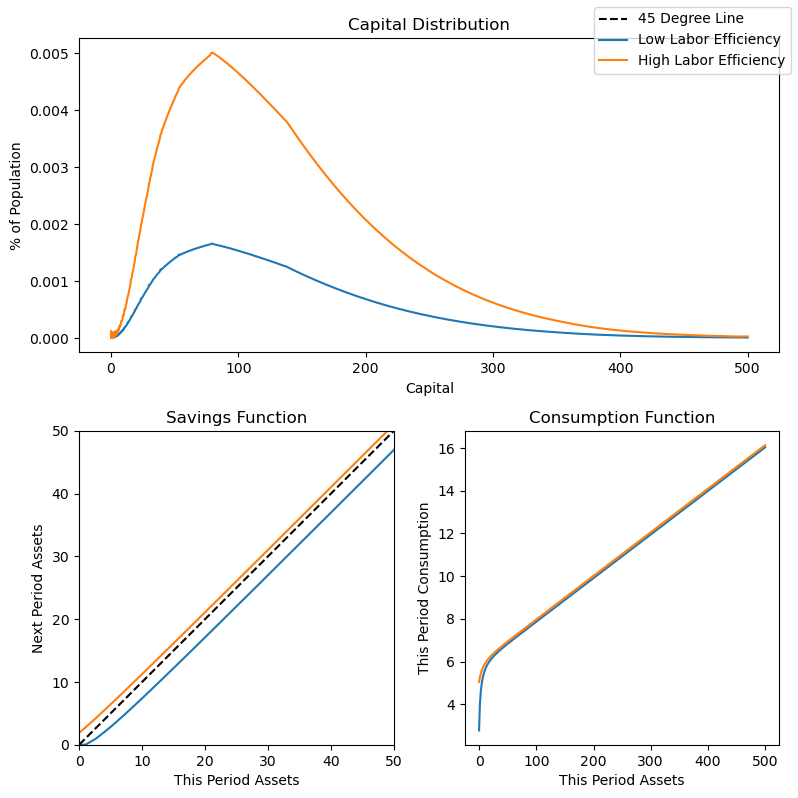

In [5]:
# initial guess
# initial guess for K
K_0 = ((1/BETA - 1 + DELTA) / (ALPHA * L**(1-ALPHA)))**(1/(ALPHA - 1))  # keep as seperate variable to use in loop 
R = ALPHA * K_0**(ALPHA-1) * L**(1-ALPHA) + 1 - DELTA
W = (1-ALPHA) * K_0**ALPHA * L**(-ALPHA)

# capital guess loop params
capital_max_iter = 100  # max number of gueses for capital
capital_tol = 1e-10  # actual capital will be within this distance of capital

# policy function loop params
policy_max_iter = 10000  # max number of guesses for the policy function
policy_tol = 1e-10  # loop until two iterations are within this distance max of each other

# params
a_current = 10 + 0.1*tiled_grid  # assumed policy function is that you save this amount from each point in the tiled grid
g = get_g(a_current)
c = get_c(g, R, W)
current_funcs = [g, c]  # we store the functions in a mutable object so the last iterations function can be used for the next iteration

# simulation function
def simulate_K(K, tol=policy_tol, max_iter=policy_max_iter):
    g, c = current_funcs

    # find r and w based on our current guess
    R = ALPHA * K**(ALPHA-1) * L**(1-ALPHA) + 1 - DELTA
    W = (1-ALPHA) * K**ALPHA * L**(-ALPHA)

    ## find policy function for this capital level
    for _ in range(max_iter):
        # update rule
        c_prime = c(tiled_grid)
        deriv_u_prime = c_prime**(-GAMMA)
        expect_deriv_u_prime = deriv_u_prime @ TRAN_MAT  # expectation
        c_current = (BETA * R * expect_deriv_u_prime)**(-1/GAMMA)
        a_current = 1/R * (c_current + tiled_grid - W*LABOR_EFFICIENCY)

        # make functions
        g, last_g = get_g(a_current), g
        c = get_c(g, R, W)

        # exit conditions
        diff = np.abs(g(tiled_grid) - last_g(tiled_grid)).max()
        if diff < tol:
            break
    else:
        warnings.warn('Policy Loop: Max iteration count exceeded')

    ## get the stationary distribution of capital
    grid_save = g(tiled_grid)  # how much you save at each gridpoint
    idxs = np.minimum(np.searchsorted(grid, grid_save, 'right'), N_A-1)  # upper of the two adjacent indicies to where g maps
    p_l = np.maximum((grid[idxs] - grid_save) / (grid[idxs] - grid[idxs-1]), 0)  # how close it is to the lower of the gridpoints we map to 
    # 1 -> it maps to the lower girdpoint, 0 -> it maps to the higher girdpoint, 0.5 -> its halfway between both
    p_h = 1 - p_l  # how close it is to the upper half

    # create transition matricies
    # low wage: capital now -> capital later
    data_l = np.concatenate([p_l[:, 0], p_h[:, 0]])
    mask_l = data_l != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_l = data_l[mask_l]
    row_l = np.concatenate([idxs[:, 0]-1, idxs[:, 0]])[mask_l]
    col_l = np.concatenate([np.arange(N_A), np.arange(N_A)])[mask_l]
    tran_mat_l = sparse.csr_array((data_l, (row_l, col_l)), shape=(N_A, N_A))

    # high wage: capital now -> capital later
    data_h = np.concatenate([p_l[:, 1], p_h[:, 1]])
    mask_h = data_h != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_h = data_h[mask_h]
    row_h = np.concatenate([idxs[:, 1]-1, idxs[:, 1]])[mask_h]
    col_h = np.concatenate([np.arange(N_A), np.arange(N_A)])[mask_h]
    tran_mat_h = sparse.csr_array((data_h, (row_h, col_h)), shape=(N_A, N_A))

    # create overall transition matrix
    tran_mat = sparse.hstack([
            sparse.vstack(np.kron(tran_mat_l, TRAN_MAT[:, 0])),  # left side of transition matrix, capital with low efficiency -> capital and efficiency next period
            sparse.vstack(np.kron(tran_mat_h, TRAN_MAT[:, 1]))  # right side of transition matrix, capital with high efficiency -> capital and efficiency next period
        ])

    # use eigenvalues to get the steady state distribution of capital
    dist = sparse.linalg.eigs(tran_mat, k=1)[1].real  # get dominant eigenvector
    dist /= dist.sum()  # normalize to sume to 1
    dist = dist.reshape((-1, 2), order='F')  # reshape to keep track of labor efficiency state, first column is low, second is high

    # get aggregate demand
    K_d = (grid * dist.T).sum()

    current_funcs[0], current_funcs[1] = g, c
    return K_d, R, W, c, g, dist

# find equalibrium
K = brentq(lambda K: simulate_K(K)[0] - K, K_0, K_0+25., xtol=capital_tol, maxiter=capital_max_iter)
_, R, W, c, g, dist = simulate_K(K)  # get the economic variables

# setup plot
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(8)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Capital Distribution')
axtop.set_xlabel('Capital')
axtop.set_ylabel('% of Population')
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('Next Period Assets')
axs[1, 0].set_xlim((0, 50))  # all the interesting stuff happens closer to 0
axs[1, 0].set_ylim((0, 50))
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('This Period Consumption')

# plot it
axtop.plot(grid, dist[:, 0], label='Low Labor Efficiency')
axtop.plot(grid, dist[:, 1], label='High Labor Efficiency')
axs[1, 0].plot(grid, g(tiled_grid))
axs[1, 0].plot([A_MIN, A_MAX], [A_MIN, A_MAX], 'k--', label='45 Degree Line')
axs[1, 1].plot(grid, c(tiled_grid))

# final things
fig.legend()
fig.tight_layout()

#### Notation
In python, the variable name will tell us whether it represents a path, a variable at a certain time, or a steady state.
- The steady states will simply be given their names (ex. Steady state capital will be `K`). These will be unaltered in the code after this
- Paths will have `_path` after their name (ex. The path for capital will be `K_path`). Some of these will begin at $t=0$ when the shock happens (ex. `Z_path`) and some will begin at $t=-1$ right before the shock happens (ex. `K_path`). The latter will be noted in a comment when initially defined.
- Variables at a certain time, especially those in a loop, will be named after their time relative to the value in the loop. If it's one period before the loop period, it will have `_l` (lag) appended to it. If it's at the time of the loop, it will have `_t` appended to it. If it's one period after the time of the loop, it will have `_p` (plus) appended to it.

Any exceptions to these rules will be clearly marked with a comment

#### Shock Path
Create the path $\{Z_t\}_{t=0}^T$. The path is defined as
$$
Z_t = \begin{cases} Z_s \quad \text{if } t < \tau \\ 1 \quad \text{otherwise} \end{cases}
$$
where $Z_s$ is the shock value of $Z_t$.

In [6]:
Z_path = np.ones(T)  # steady state
Z_path[10:TAU+10] *= Z_SHOCK  # shock happens for first tau indexes

Z_path

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1.1, 1.1, 1.1,
       1.1, 1.1, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1.

#### Initial Guess
Our initial guess for $\{K_t\}_{t=0}^T$ will be that it stays the steady state the whole time. Then, we'll use the production FOCs to solve for $\{R_t, W_t\}_{t=0}^T$.

\begin{align*}
R_t &= \alpha Z_t K_{t-1}^{\alpha - 1} L_t^{\alpha - 1} + 1 - \delta \\
W_t &= (1-\alpha) Z_t K_{t-1}^\alpha L_t^{-\alpha}.
\end{align*}

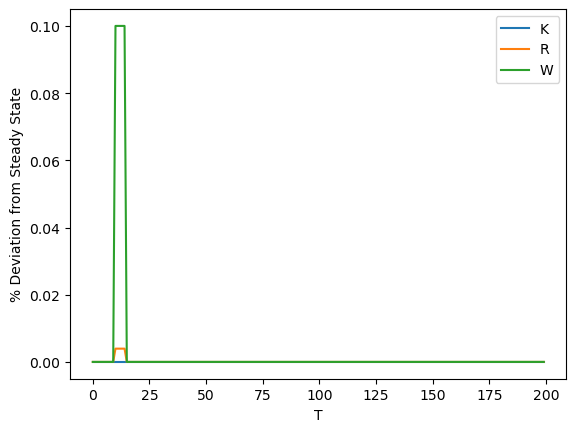

In [7]:
# guess K
K_path_0 = np.full_like(Z_path, K)  # this is lagged 1 period
K_path = K_path_0

# solve for R and W
R_path = Z_path * ALPHA * K_path**(ALPHA-1) * L**(1-ALPHA) + 1 - DELTA
W_path = Z_path * (1-ALPHA) * K_path**ALPHA * L**(-ALPHA)

# plot values over time
plt.xlabel('T')
plt.ylabel('% Deviation from Steady State')
plt.plot(range(T), (K_path - K) / K, label='K')
plt.plot(range(T), (R_path - R) / R, label='R')
plt.plot(range(T), (W_path - W) / W, label='W')
plt.legend()

#### Solve For Policy Functions
We use the prices to solve for policy functions. To do this, we implement the same expression used in the endogenous grid method where we assume some level of next period savings $k_t$, we just add a time subscript to get
$$
c_t = \left(\beta R_{t+1} \mathbb{E} \left[\left(R_{t+1} k_t + W_{t+1} \ell_{i, t+1} - g_{t+1} (k_t, \ell_{i, t+1})\right)^{-\gamma}\right]\right)^\frac{-1}{\gamma}
$$
and then
$$
k_{t-1} = \frac{1}{R_t} (c_t + k_t - W_t \ell_{i, t}).
$$
Then, we get $g_t$ by mapping from $k_{t-1}$ to $A$.

In [8]:
# paths, we edit (almost) starting from the end, so intialize list with nothing in it we can edit
g_path = [None for _ in range(T)]
c_path = [None for _ in range(T)]
g_t = g  # end functions are steady state
c_t = c
for t in range(T)[::-1]:
    # get prices
    R_l, R_t = R_path[t-1], R_path[t]
    W_l = W_path[t-1]

    # update rule
    c_prime = c_t(tiled_grid)
    deriv_u_prime = c_prime**(-GAMMA)
    expect_deriv_u_prime = deriv_u_prime @ TRAN_MAT  # expectation
    c_current = (BETA * R_t * expect_deriv_u_prime)**(-1/GAMMA)
    a_current = 1/R_l * (c_current + tiled_grid - W_l*LABOR_EFFICIENCY)

    # make functions
    g_t = get_g(a_current)
    c_t = get_c(g_t, R_l, W_l)
    g_path[t-1] = g_t
    c_path[t-1] = c_t

len(g_path), len(c_path)

(200, 200)

In [9]:
## animate it (this is slow, so it's seperated)
# setup plot
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(8)
fig.set_figheight(4)
ax[0].set_title('Savings')
ax[0].set_xlabel('This Period Assets')
ax[0].set_ylabel('Next Period Assets')
ax[1].set_title('Consumption')
ax[1].set_xlabel('This Period Assets')
ax[1].set_ylabel('This Period Consumption')

# plot it
fig.suptitle('t=0')
ln_g_low, = ax[0].plot([], [], label='Low')
ln_g_high, = ax[0].plot([], [], label='High')
ax[0].plot([A_MIN, A_MAX], [A_MIN, A_MAX], 'k--', label='45 Degree Line')
ax[0].set_xlim((0, 50))  # all the interesting stuff happens closer to 0
ax[0].set_ylim((0, 50))
ln_c_low, = ax[1].plot([], [])
ln_c_high, = ax[1].plot([], [])
ax[1].set_xlim((A_MIN, A_MAX))
ax[1].set_ylim((0, 16))

# final things
ax[0].legend()
fig.tight_layout()

def update(t):
    fig.suptitle(f't={t}')

    # update savings
    savings = g_path[t](tiled_grid)
    ln_g_low.set_data(grid, savings[:, 0])
    ln_g_high.set_data(grid, savings[:, 1])

    # update consumption
    consumption = c_path[t](tiled_grid)
    ln_c_low.set_data(grid, consumption[:, 0])
    ln_c_high.set_data(grid, consumption[:, 1])

# animate it
plt.close()  # dont show empty figure
anim = animation.FuncAnimation(fig, update, frames=T, interval=50, repeat=False)
HTML(anim.to_html5_video())

#### Estimate the Distribution
For each production function, we'll create a transition matrix $T_t$ for asset holdings and idiosyncratic shocks. Then, we'll calculate the distribution over time so that
$$
\Gamma_t = T_t \Gamma_{t-1}.
$$
The first wealth distribution, $\Gamma_{-1}$, will be the steady state.

In [10]:
# find distributions
dist_path = [None for _ in range(T)]
dist_t = dist  # intiialize with steady state
dist_path[0] = dist_t
for t in range(1, T):
    ## get the stationary distribution of capital
    grid_save = g_path[t-1](tiled_grid)  # how much you save at each gridpoint
    idxs = np.minimum(np.searchsorted(grid, grid_save, 'right'), N_A-1)  # upper of the two adjacent indicies to where g maps
    p_l = np.maximum((grid[idxs] - grid_save) / (grid[idxs] - grid[idxs-1]), 0)  # how close it is to the lower of the gridpoints we map to 
    # 1 -> it maps to the lower girdpoint, 0 -> it maps to the higher girdpoint, 0.5 -> its halfway between both
    p_h = 1 - p_l  # how close it is to the upper half

    # create transition matricies
    # low wage: capital now -> capital later
    data_l = np.concatenate([p_l[:, 0], p_h[:, 0]])
    mask_l = data_l != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_l = data_l[mask_l]
    row_l = np.concatenate([idxs[:, 0]-1, idxs[:, 0]])[mask_l]
    col_l = np.concatenate([np.arange(N_A), np.arange(N_A)])[mask_l]
    tran_mat_l = sparse.csr_array((data_l, (row_l, col_l)), shape=(N_A, N_A))

    # high wage: capital now -> capital later
    data_h = np.concatenate([p_l[:, 1], p_h[:, 1]])
    mask_h = data_h != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_h = data_h[mask_h]
    row_h = np.concatenate([idxs[:, 1]-1, idxs[:, 1]])[mask_h]
    col_h = np.concatenate([np.arange(N_A), np.arange(N_A)])[mask_h]
    tran_mat_h = sparse.csr_array((data_h, (row_h, col_h)), shape=(N_A, N_A))

    # create overall transition matrix
    tran_mat = sparse.hstack([
            sparse.vstack(np.kron(tran_mat_l, TRAN_MAT[:, 0])),  # left side of transition matrix, capital with low efficiency -> capital and efficiency next period
            sparse.vstack(np.kron(tran_mat_h, TRAN_MAT[:, 1]))  # right side of transition matrix, capital with high efficiency -> capital and efficiency next period
        ])
    
    # get distribution
    dist_t = tran_mat @ dist_t.ravel('F')  # multiply last period distibution to getnext period
    dist_t = dist_t.reshape((-1, 2), order='F')  # reshape to keep track of labor efficiency state, first column is low, second is high
    dist_path[t] = dist_t

len(dist_path)

200

In [11]:
## animate it (this is slow, so it's seperated)
# setup plot
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(4)
fig.suptitle('t=0')
ax.set_title('Capital Distribution')
ax.set_xlabel('Capital')
ax.set_ylabel('% of Population')

# plot it
ln_dist_low, = ax.plot([], [], label='Low Labor Efficiency')
ln_dist_high, = ax.plot([], [], label='High Labor Efficiency')
ax.set_xlim((A_MIN, A_MAX))
ax.set_ylim((0, 0.006))

# final things
ax.legend()
fig.tight_layout()

def update(t):
    fig.suptitle(f't={t}')

    # update distribution
    dist_t = dist_path[t]
    ln_dist_low.set_data(grid, dist_t[:, 0])
    ln_dist_high.set_data(grid, dist_t[:, 1])

# animate it
plt.close()  # dont show empty figure
anim = animation.FuncAnimation(fig, update, frames=T, interval=50, repeat=False)
HTML(anim.to_html5_video())

#### Aggregate Capital
Use our distribution to get aggregate capital at each time period and compare it to our guess

In [12]:
K_agg_path = np.array([(grid * dist.T).sum() for dist in dist_path])
K_agg_path - K_path

array([7.55866324e-07, 3.99482331e-02, 8.07131676e-02, 1.22310995e-01,
       1.64756911e-01, 2.08066092e-01, 2.52253623e-01, 2.97333700e-01,
       3.43321204e-01, 3.90227599e-01, 4.38061984e-01, 1.43876330e+00,
       2.43270031e+00, 3.41963337e+00, 4.39931482e+00, 5.37149141e+00,
       5.36489900e+00, 5.35838130e+00, 5.35193604e+00, 5.34555984e+00,
       5.33925018e+00, 5.33300433e+00, 5.32682004e+00, 5.32069486e+00,
       5.31462657e+00, 5.30861317e+00, 5.30265275e+00, 5.29674355e+00,
       5.29088393e+00, 5.28507237e+00, 5.27930742e+00, 5.27358773e+00,
       5.26791203e+00, 5.26227912e+00, 5.25668787e+00, 5.25113718e+00,
       5.24562605e+00, 5.24015349e+00, 5.23471858e+00, 5.22932044e+00,
       5.22395821e+00, 5.21863110e+00, 5.21333833e+00, 5.20807916e+00,
       5.20285288e+00, 5.19765880e+00, 5.19249627e+00, 5.18736466e+00,
       5.18226336e+00, 5.17719179e+00, 5.17214937e+00, 5.16713557e+00,
       5.16214985e+00, 5.15719171e+00, 5.15226066e+00, 5.14735622e+00,
      

#### Combined Algorithm
We run all the previous steps in a loop until $K_t = \tilde{K}_t$. The only additional step is to create our next guess we use the convex combination of $K_t$ and $\tilde{K}_t$
$$
w K_t + (1-w) \tilde{K}_t
$$

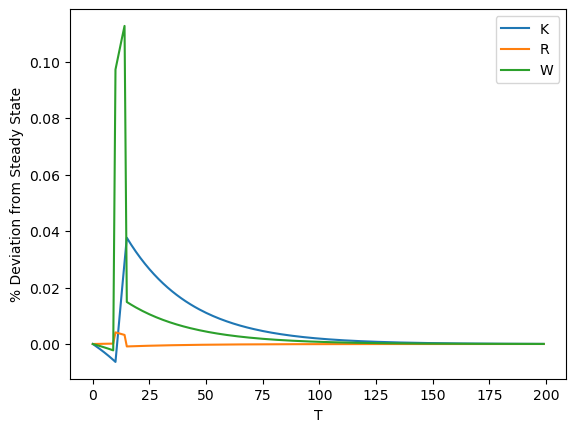

In [13]:
# initialize it
K_path = K_path_0
w = 0.8

# capital guess loop params
capital_max_iter = 250  # max number of gueses for capital
capital_tol = 1e-10  # actual capital will be within this distance of capital
w = 0.8

# policy function loop params
policy_max_iter = 10000  # max number of guesses for the policy function
policy_tol = 1e-10  # loop until two iterations are within this distance max of each other

# loop
for _ in range(capital_max_iter):
    # find prices
    R_path = Z_path * ALPHA * K_path**(ALPHA-1) * L**(1-ALPHA) + 1 - DELTA
    W_path = Z_path * (1-ALPHA) * K_path**ALPHA * L**(-ALPHA)

    # get policy functions
    g_path = [None for _ in range(T)]
    c_path = [None for _ in range(T)]
    g_t = g  # end functions are steady state
    c_t = c
    for t in range(T)[::-1]:
        # get prices
        R_l, R_t = R_path[t-1], R_path[t]
        W_l = W_path[t-1]

        # update rule
        c_prime = c_t(tiled_grid)
        deriv_u_prime = c_prime**(-GAMMA)
        expect_deriv_u_prime = deriv_u_prime @ TRAN_MAT  # expectation
        c_current = (BETA * R_t * expect_deriv_u_prime)**(-1/GAMMA)
        a_current = 1/R_l * (c_current + tiled_grid - W_l*LABOR_EFFICIENCY)

        # make functions
        g_t = get_g(a_current)
        c_t = get_c(g_t, R_l, W_l)
        g_path[t-1] = g_t
        c_path[t-1] = c_t

    # get wealth distributions
    dist_path = [None for _ in range(T)]
    dist_t = dist  # intiialize with steady state
    dist_path[0] = dist_t
    for t in range(1, T):
        ## get the stationary distribution of capital
        grid_save = g_path[t-1](tiled_grid)  # how much you save at each gridpoint
        idxs = np.minimum(np.searchsorted(grid, grid_save, 'right'), N_A-1)  # upper of the two adjacent indicies to where g maps
        p_l = np.maximum((grid[idxs] - grid_save) / (grid[idxs] - grid[idxs-1]), 0)  # how close it is to the lower of the gridpoints we map to 
        # 1 -> it maps to the lower girdpoint, 0 -> it maps to the higher girdpoint, 0.5 -> its halfway between both
        p_h = 1 - p_l  # how close it is to the upper half

        # create transition matricies
        # low wage: capital now -> capital later
        data_l = np.concatenate([p_l[:, 0], p_h[:, 0]])
        mask_l = data_l != 0  # there can be zeros when a point perfectly matches a girdpoint
        data_l = data_l[mask_l]
        row_l = np.concatenate([idxs[:, 0]-1, idxs[:, 0]])[mask_l]
        col_l = np.concatenate([np.arange(N_A), np.arange(N_A)])[mask_l]
        tran_mat_l = sparse.csr_array((data_l, (row_l, col_l)), shape=(N_A, N_A))

        # high wage: capital now -> capital later
        data_h = np.concatenate([p_l[:, 1], p_h[:, 1]])
        mask_h = data_h != 0  # there can be zeros when a point perfectly matches a girdpoint
        data_h = data_h[mask_h]
        row_h = np.concatenate([idxs[:, 1]-1, idxs[:, 1]])[mask_h]
        col_h = np.concatenate([np.arange(N_A), np.arange(N_A)])[mask_h]
        tran_mat_h = sparse.csr_array((data_h, (row_h, col_h)), shape=(N_A, N_A))

        # create overall transition matrix
        tran_mat = sparse.hstack([
                sparse.vstack(np.kron(tran_mat_l, TRAN_MAT[:, 0])),  # left side of transition matrix, capital with low efficiency -> capital and efficiency next period
                sparse.vstack(np.kron(tran_mat_h, TRAN_MAT[:, 1]))  # right side of transition matrix, capital with high efficiency -> capital and efficiency next period
            ])
        
        # get distribution
        dist_t = tran_mat @ dist_t.ravel('F')  # multiply last period distibution to getnext period
        dist_t = dist_t.reshape((-1, 2), order='F')  # reshape to keep track of labor efficiency state, first column is low, second is high
        dist_path[t] = dist_t

    # aagregate capital
    K_agg_path = np.array([(grid * dist.T).sum() for dist in dist_path])
    if np.abs(K_agg_path - K_path).max() < capital_tol:  # if everything is within the tolerance
        break
    K_path = w * K_path + (1-w) * K_agg_path
else:
    warnings.warn('Capital Loop: Max iteration count exceeded')

# plot values over time
plt.xlabel('T')
plt.ylabel('% Deviation from Steady State')
plt.plot(range(T), (K_path - K) / K, label='K')
plt.plot(range(T), (R_path - R) / R, label='R')
plt.plot(range(T), (W_path - W) / W, label='W')
plt.legend()

In [14]:
# animation
# setup plot
fig, axs = plt.subplots(2, 2)
fig.suptitle('t=0')
fig.set_figwidth(8)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Capital Distribution')
axtop.set_xlabel('Capital')
axtop.set_ylabel('% of Population')
axtop.set_xlim((A_MIN, A_MAX))
axtop.set_ylim((0, 0.006))
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('Next Period Assets')
axs[1, 0].set_xlim((0, 50))  # all the interesting stuff happens closer to 0
axs[1, 0].set_ylim((0, 50))
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('This Period Consumption')
axs[1, 1].set_xlim((A_MIN, A_MAX))
axs[1, 1].set_ylim((0, 16))

# plot it
ln_dist_low, = axtop.plot([], [], label='Low Labor Efficiency')
ln_dist_high, = axtop.plot([], [], label='High Labor Efficiency')
ln_g_low, = axs[1, 0].plot([], [])
ln_g_high, = axs[1, 0].plot([], [])
axs[1, 0].plot([A_MIN, A_MAX], [A_MIN, A_MAX], 'k--', label='45 Degree Line')
ln_c_low, = axs[1, 1].plot([], [])
ln_c_high, = axs[1, 1].plot([], [])

# final things
fig.legend()
fig.tight_layout()

# update frame
def update(t):
    fig.suptitle(f't={t}')

    # update distribution
    dist_t = dist_path[t]
    ln_dist_low.set_data(grid, dist_t[:, 0])
    ln_dist_high.set_data(grid, dist_t[:, 1])

    # update savings
    savings = g_path[t](tiled_grid)
    ln_g_low.set_data(grid, savings[:, 0])
    ln_g_high.set_data(grid, savings[:, 1])

    # update consumption
    consumption = c_path[t](tiled_grid)
    ln_c_low.set_data(grid, consumption[:, 0])
    ln_c_high.set_data(grid, consumption[:, 1])
    

# animate it
plt.close()  # dont show empty figure
anim = animation.FuncAnimation(fig, update, frames=T, interval=50, repeat=False)
HTML(anim.to_html5_video())